In [10]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import dataSource as ds

# Parametrage

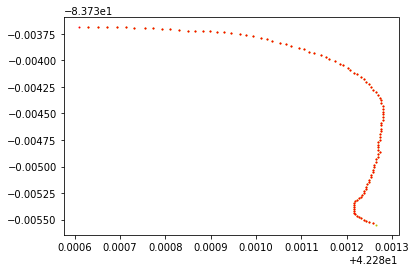

In [2]:
from sklearn.model_selection import train_test_split

df = ds.importData()

def treat(df, batch_size, train_size, step):

    df = df.sort_values(by="GpsTime")
    
    df = df[df["Trip"] == 57]

    data = df[["Latitude","Longitude"]]
    
    step = step//200

    N = len(data)
    train_df, test_df = data[:int(N*train_size)], data[int(N*train_size):]

    X_train = ds.echantillon(train_df[:-step], step).to_numpy()
    y_train = ds.echantillon(train_df[step:], step).to_numpy()

    X_test = ds.echantillon(test_df[:-step], step).to_numpy()
    y_test = ds.echantillon(test_df[step:], step).to_numpy()

    return X_train, y_train, X_test, y_test

batch_size,train_size,step = 32, 0.8, 200

X_train, y_train, X_test, y_test = treat(df, batch_size, train_size, step)

plt.scatter(X_train[:, 0], X_train[:, 1], s = 1, c = 'y')
plt.scatter(y_train[:, 0], y_train[:, 1], s = 1, c = 'r')
plt.show()



In [3]:
#dataset
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

dataset = timeseries(X_train,y_train)
#dataloader
from torch.utils.data import DataLoader 
train_loader = DataLoader(dataset,shuffle=False,batch_size=batch_size, drop_last = True)

# verify train_loader, especially check if batches are all consecutives
'''
torch.set_printoptions(sci_mode=False)
l = list(train_loader)
print(l[0], l[1])
'''


'\ntorch.set_printoptions(sci_mode=False)\nl = list(train_loader)\nprint(l[0], l[1])\n'

In [4]:
# rnn
#neural network
from torch import nn

class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, state):
        """As we divided data into batches, to respect time order, every forward should take previous state and, produces a new state"""

        #Initializing hidden state for first input using method defined below
        #hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, new_state = self.lstm(x, state)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, new_state
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = ( torch.zeros((self.n_layers, batch_size, self.hidden_dim)), torch.zeros((self.n_layers, batch_size, self.hidden_dim)) )
        return hidden


In [5]:
# Instantiate the model with hyperparameters

device = torch.device("cpu")

input_size = output_size = 2 # len(["Latitude","Longitude"])
# Define hyperparameters

lr = 1e-2
num_hiddens = 256 # n. hidden units
num_layer = 1   # 1 single rnn_layer
                # multiple layers are possible but we start with a single one..

model = Model(input_size=input_size, output_size=output_size, hidden_dim=num_hiddens, n_layers=num_layer)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)


# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [6]:
# raw output
#init_state = model.init_hidden(batch_size)
#model(list(train_loader)[0], init_state)


In [7]:
# training 

def grad_clipping(net, theta): 
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


epochs = 500

state = model.init_hidden(batch_size) # init state, dim (n_layers, batch_size, hidden_dim)

for i in range(epochs):
    for j, data in enumerate(train_loader):
        #print(data.shape, data)
        #print(data[0].view(1, batch_size, input_size).shape)

        y_pred, state = model(data[0].view(1, batch_size, input_size), state)
        
        loss = criterion(y_pred,data[1])
        
        for s in state:
            s.detach_()

        optimizer.zero_grad()
        loss.backward() # each successive batch will take more time than the previous one because it will have to back-propagate all the way through to the start of the first batch.
        grad_clipping(model, 1)
        optimizer.step()
    if i%50 == 0:
        print(i,"th iteration : ",loss)


0 th iteration :  tensor(4058.4187, grad_fn=<MseLossBackward>)
50 th iteration :  tensor(0.0138, grad_fn=<MseLossBackward>)
100 th iteration :  tensor(0.0112, grad_fn=<MseLossBackward>)
150 th iteration :  tensor(0.0085, grad_fn=<MseLossBackward>)
200 th iteration :  tensor(0.0068, grad_fn=<MseLossBackward>)
250 th iteration :  tensor(0.0056, grad_fn=<MseLossBackward>)
300 th iteration :  tensor(0.0053, grad_fn=<MseLossBackward>)
350 th iteration :  tensor(0.0597, grad_fn=<MseLossBackward>)
400 th iteration :  tensor(0.0131, grad_fn=<MseLossBackward>)
450 th iteration :  tensor(0.0098, grad_fn=<MseLossBackward>)


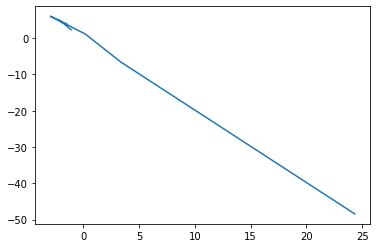

In [8]:
# test set actual vs predicted

def pred(input, num_future, model):
    """
    take last output as next input; init hidden state = zeros ; take last hidden state as next hidden state.
    
    input : prefix data points (X_test when scoring)
    num_future : number of points we want to predict, (0 when scoring)
    
    """
    batch_size=1
    
    state = model.init_hidden(batch_size=batch_size) 

    output = [] # first point

    for i in range(len(input) + num_future):
        if i == 0:
            yhat, state = model(input[0].view(-1, batch_size, 2), state)    
        else:
            yhat, state = model(output[-1].view(-1, batch_size, 2), state)
        #print(yhat, output[-1])
        if i < len(input) - 1:
            output.append(input[i+1])
        else:
            output.append(yhat.detach())

    return output

output = pred(torch.Tensor([[-1.5134,  1.3806]]), 10, model)
plt.plot([e[0][0].item() for e in output], [e[0][1].item() for e in output], label='predicted{}'.format((j)))

RuntimeError: shape '[1, 32, 2]' is invalid for input of size 1

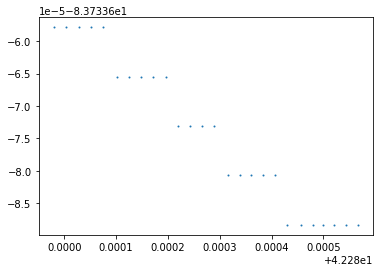

In [9]:

test_set = timeseries(X_test,y_test)
#test_loader = DataLoader(test_set,shuffle=False,batch_size=batch_size, drop_last = True)

#state_pred = state

plt.scatter(test_set.y[:,0],test_set.y[:,1], s = 1,label='original')

for j, data in enumerate(test_set.x):
    
    y_pred, state_pred = model(data[0].view(1,batch_size,input_size), state_pred) # state was well trained after iteration
    
    tmp = y_pred.detach().numpy()
    
    plt.scatter(tmp[:,0], tmp[:,1], s = 1, label='predicted{}'.format((j)))


    plt.legend()